In [ ]:
pip install playwright pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 42.3 MB/s eta 0:00:00


In [ ]:
!playwright install chromium

164.5 MiB [] 0% 10.9s164.5 MiB [] 0% 22.2s164.5 MiB [] 0% 11.1s164.5 MiB [] 0% 8.2s164.5 MiB [] 0% 7.8s164.5 MiB [] 1% 6.6s164.5 MiB [] 1% 5.9s164.5 MiB [] 2% 5.7s164.5 MiB [] 2% 5.5s164.5 MiB [] 2% 5.6s164.5 MiB [] 3% 5.9s164.5 MiB [] 3% 5.5s164.5 MiB [] 3% 5.3s164.5 MiB [] 4% 5.5s164.5 MiB [] 4% 5.9s164.5 MiB [] 4% 6.0s164.5 MiB [] 4% 5.8s164.5 MiB [] 5% 5.5s164.5 MiB [] 5% 5.3s164.5 MiB [] 6% 5.3s164.5 MiB [] 6% 5.1s164.5 MiB [] 7% 4.9s164.5 MiB [] 7% 4.6s164.5 MiB [] 8% 4.5s164.5 MiB [] 8% 4.4s164.5 MiB [] 9% 4.5s164.5 MiB [] 9% 4.4s164.5 MiB [] 10% 4.3s164.5 MiB [] 10% 4.2s164.5 MiB [] 11% 4.2s164.5 MiB [] 12% 4.1s164.5 MiB [] 13% 4.1s164.5 MiB [] 13% 4.0s164.5 MiB [] 14% 3.9s164.5 MiB [] 15% 3.8s164.5 MiB [] 16% 3.7s164.5 MiB [] 17% 3.7s164.5 MiB [] 17% 3.6s164.5 MiB [] 18% 3.5s164.5 MiB [] 19% 3.4s164.5 MiB [] 19% 3.3s164.5 MiB [] 20% 3.3s164.5 MiB [] 20% 3.2s164.5 MiB [] 21% 3.1s164.5 MiB [] 22% 3.1s164.5 MiB [] 23% 3.0s164.5 MiB [] 23% 2.9s164.5 MiB [] 24% 2.9s164.5 MiB [] 25%

In [ ]:
!pip install nest_asyncio

In [ ]:
!pip install mpld3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 7.0 MB/s eta 0:00:00


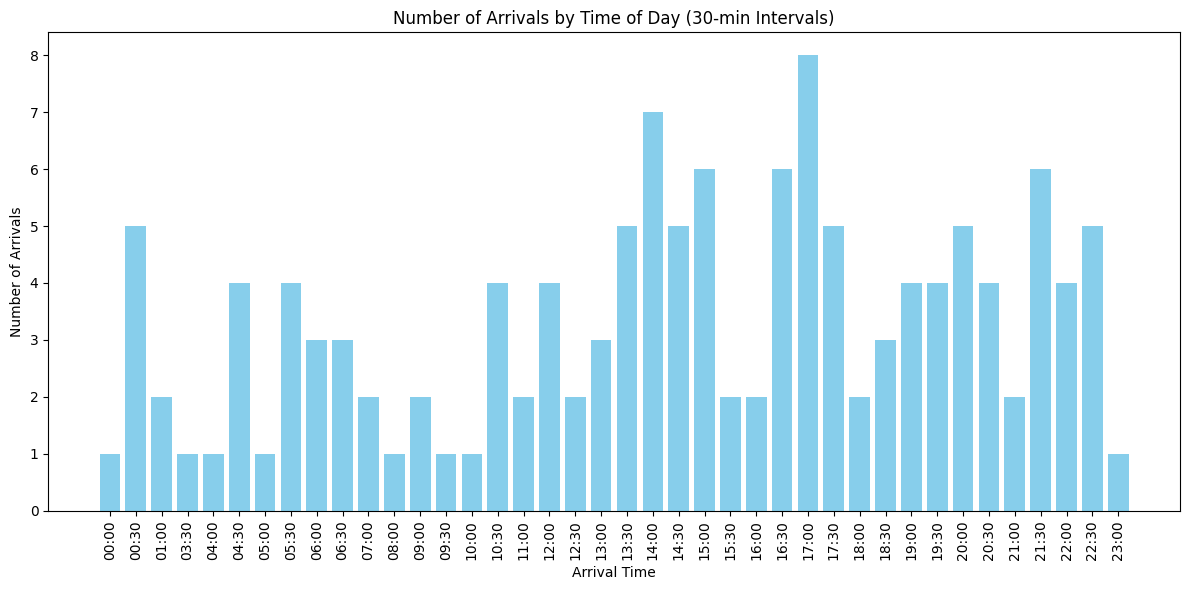

データを haneda_flights_20241114_023640.csv に保存しました


,status,scheduledTime,changedTime,airport,terminal,gate
2,到着済み,04:57,ロサンゼルス,,78E,T2
1,到着済み,05:14,ニューヨーク（JFK),,77N,T2
0,到着済み,05:33,シドニー,,78I,T2
3,到着済み,05:49,シンガポール,,78I,T2
6,到着済み,06:29,ミュンヘン,,78I,T2
4,到着済み,06:32,バンコク（BKK）,,780,T2
5,到着済み,06:50,ジャカルタ,,788,T2
7,到着済み,09:36,ソウル（金浦）,,788,T2
8,,11:47,上海（浦東）,,76E,T2
9,,15:32,パリ（CDG）,,78I,T2


T2のフライト:


In [ ]:
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from playwright.async_api import async_playwright
import asyncio

class HanedaFlightScraper:
    def __init__(self):
        self.url = "https://tokyo-haneda.com/flight/flightInfo_int.html"

    async def __aenter__(self):
        self.playwright = await async_playwright().start()
        self.browser = await self.playwright.chromium.launch(headless=True)
        self.page = await self.browser.new_page()
        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        await self.browser.close()
        await self.playwright.stop()

    async def setup_page(self):
        """ページの初期設定を行う"""
        await self.page.goto(self.url)
        await self.page.wait_for_load_state('networkidle')
        await self.page.wait_for_selector('.flight-timeTable-timeZone')

    async def select_all_flights(self):
        """全便表示を選択"""
        try:
            await self.page.locator("input[value='int-arrival']").check()
            await self.page.wait_for_load_state('networkidle')
            await asyncio.sleep(2)
            await self.page.select_option('.flight-timeTable-timeZone.select', value='全便を見る')
            await self.page.wait_for_load_state('networkidle')
            await asyncio.sleep(2)
        except Exception as e:
            print(f"全便表示の選択中にエラーが発生: {str(e)}")

    async def get_flight_data(self):
        """フライト情報を取得"""
        try:
            flights = await self.page.evaluate("""() => {
                const rows = document.querySelectorAll('.flight-timeTable-pc tr');
                return Array.from(rows).map(row => {
                    const cells = row.querySelectorAll('td');
                    return {
                    status: cells[0] ? cells[0].textContent.trim() : '',
                    scheduledTime: cells[1] ? cells[1].textContent.trim() : '',
                    changedTime: cells[2] ? cells[2].textContent.trim() : '',
                    airport: cells[3] ? cells[3].textContent.trim() : '',
                    terminal: cells[6] ? cells[6].textContent.trim() : '',
                    gate: cells[7] ? cells[7].textContent.trim() : ''
                    };
                });
            }""")
            # フライトデータから有効な時刻のみを返す
            # フライトデータをターミナルで分けて返す
            other_flights = [self.format_flight_time(flight) for flight in flights if flight['scheduledTime'] and flight['gate'] != 'T2']
            t2_flights = [self.format_flight_time(flight) for flight in flights if flight['scheduledTime'] and flight['gate'] == 'T2']
            return other_flights, t2_flights

            return [self.format_flight_time(flight) for flight in flights if flight['scheduledTime']]
        except Exception as e:
            print(f"フライトデータの取得中にエラーが発生: {str(e)}")
            return []

    def format_flight_time(self, flight):
        """フライトの到着時刻をフォーマット"""
        time_pattern = r"(\d{2}:\d{2})(?:\[(\d{2}:\d{2}| - )\])?"  # パターンを修正
        match = re.match(time_pattern, flight['scheduledTime'])

        if match:
            if match.group(2) and match.group(2) != ' - ':  # 条件を追加
                flight['scheduledTime'] = match.group(2)  # [HH:MM] 部分を採用
            else:
                flight['scheduledTime'] = match.group(1)  # HH:MM 部分を採用
        else:
            flight['scheduledTime'] = None

        return flight

    def count_arrivals_by_time(self, flight_data):
        """到着便数を30分ごとにカウント"""
        arrival_counts = defaultdict(int)
        for flight in flight_data:
            # 無効な時刻はスキップ
            if flight['scheduledTime']:
                rounded_time = self.round_to_nearest_half_hour(flight['scheduledTime'])
                arrival_counts[rounded_time] += 1
        return dict(arrival_counts)

    def round_to_nearest_half_hour(self, time_str):
      """時刻を30分単位に丸める"""
      hour, minute = map(int, time_str.split(":"))
      if minute < 30:
          rounded_time = f"{hour:02}:00"
      else:
          rounded_time = f"{hour:02}:30"
      return rounded_time  # 丸めた時刻を返す

    async def plot_arrivals_by_time(self, flight_data):
        """到着便数を30分ごとにプロット"""
        # 到着便数をカウント
        arrival_counts = self.count_arrivals_by_time(flight_data)

        # arrival_counts を時間でソート
        sorted_arrival_counts = dict(sorted(arrival_counts.items(), key=lambda item: datetime.strptime(item[0], '%H:%M')))


        # グラフの描画
        plt.figure(figsize=(12, 6))
        plt.bar(sorted_arrival_counts.keys(), sorted_arrival_counts.values(), color='skyblue')
        plt.xlabel('Arrival Time')
        plt.ylabel('Number of Arrivals')
        plt.title('Number of Arrivals by Time of Day (30-min Intervals)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()



    async def save_to_csv(self, data, filename=None):
        """データをCSVファイルとして保存"""
        if not filename:
            current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'haneda_flights_{current_time}.csv'

       # 空白行を削除
        data = [row for row in data if any(field.strip() for field in row.values() if isinstance(field, str))]

        df = pd.DataFrame(data)
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"データを {filename} に保存しました")

async def main():
    async with HanedaFlightScraper() as scraper:
        try:
            # 初期設定
            await scraper.setup_page()

            # 全便表示を選択
            await scraper.select_all_flights()

            # フライトデータを取得
            other_flights, t2_flights = await scraper.get_flight_data()

            # 到着便数を30分ごとの時間帯でグラフ表示
            await scraper.plot_arrivals_by_time(other_flights)

            # CSVに保存
            await scraper.save_to_csv(other_flights)

            # T2のフライトをテーブル表示
            if t2_flights:
                df_t2 = pd.DataFrame(t2_flights)
                # scheduledTime でソート
                df_t2 = df_t2.sort_values(by=['scheduledTime'], key=lambda col: pd.to_datetime(col, format='%H:%M', errors='coerce'))
                display(df_t2)
                print("T2のフライト:")

        except Exception as e:
            print(f"処理中にエラーが発生: {str(e)}")

if __name__ == "__main__":
    import sys
    if 'ipykernel' in sys.modules:
        import nest_asyncio
        nest_asyncio.apply()
    asyncio.run(main())
